
# Jour 3 — Maths Rates : Duration, DV01, Convexité

Ce notebook te donne les bases concrètes à **maîtriser en entretien Quant Dev sur desk Rates**.

- **Duration Macaulay & Modifiée** (sensibilité à la variation de taux)
- **DV01** (Dollar Value of 1 Basis Point)
- **Convexité**
- **Applications pratiques sur obligation**
- **Code Python pour calculer duration, DV01, convexité**
- **Quiz oral : interpréter les résultats et briller à l’entretien**

---



## 1. Rappels essentiels (formules, intuition)

### **Prix d’une obligation (prix “clean”, hors coupon couru) :**

$$
P = \sum_{i=1}^N \frac{C_i}{(1+r)^{t_i}}
$$

- $C_i$ = cashflow (coupon ou nominal) à la date $t_i$
- $r$ = taux d’actualisation (spot ou yield to maturity)

---

### **Duration Macaulay :**

$$
D_{Mac} = \frac{\sum_{i=1}^N t_i \frac{C_i}{(1+r)^{t_i}}}{P}
$$

- Mesure la “moyenne pondérée” des échéances, pondérées par la valeur actualisée de chaque flux

---

### **Duration Modifiée :**

$$
D_{mod} = \frac{D_{Mac}}{1+r}
$$

- Donne la sensibilité du prix pour un “petit” déplacement de taux

---

### **DV01 :**

Variation de prix pour un move de 1 bp (0.01%) de taux :

$$
DV01 = -D_{mod} \times P \times 0.0001
$$

(Signe négatif car prix baisse si taux monte)

---

### **Convexité :**

$$
Conv = \frac{1}{P} \sum_{i=1}^N t_i(t_i+1) \frac{C_i}{(1+r)^{t_i+2}}
$$

- Mesure la “courbure” de la relation prix-taux.  
- Plus une obligation est longue ou à faible coupon, plus elle est convexe.

---



## 2. Calculs sur une obligation fictive

**Supposons :**
- Nominal = 100
- Coupon annuel = 2 € (2 %)
- Maturité = 5 ans
- Taux d’actualisation = 2.5 % (0.025)


In [2]:
import numpy as np
# Paramètres de l'obligation
nominal = 100
coupon = 2
N = 5
r = 0.025

# Cashflows : 4 coupons + nominal à la fin
cashflows = [coupon] * (N-1) + [coupon + nominal]
dates = np.arange(1, N+1)

# Prix
discount_factors = [(1+r)**(-t) for t in dates]
P = sum(cf * df for cf, df in zip(cashflows, discount_factors))
print(f"Prix de l'obligation : {P:.4f}")

# Duration Macaulay
D_mac = sum(t * cf * df for t, cf, df in zip(dates, cashflows, discount_factors)) / P
print(f"Duration Macaulay : {D_mac:.4f} ans")

# Duration modifiée
D_mod = D_mac / (1 + r)
print(f"Duration modifiée : {D_mod:.4f} ans")

# DV01
dv01 = -D_mod * P * 0.0001
print(f"DV01 : {dv01:.5f} (variation du prix pour +1bp)")

# Convexité
Conv = sum(t*(t+1)*cf*df/(1+r)**2 for t, cf, df in zip(dates, cashflows, discount_factors)) / P
print(f"Convexité approx : {Conv:.4f}")


Prix de l'obligation : 97.6771
Duration Macaulay : 4.8051 ans
Duration modifiée : 4.6879 ans
DV01 : -0.04579 (variation du prix pour +1bp)
Convexité approx : 27.0745



### 📌 **À retenir pour l’oral**

- **Duration** : sensibilité linéaire du prix à un petit changement de taux
- **Convexité** : prise en compte du fait que la relation prix-taux est courbe (et non droite)
- **DV01** : combien tu perds/gagnes si le taux monte/baisse de 1bp
- Les desks rates pilotent souvent leur PnL via DV01 total !

---

### **Quiz rapide**

1. Si le taux monte de 10 bp, de combien varie le prix ? (approx. : $10 \times DV01$)
2. Pourquoi la convexité protège contre les grands mouvements de taux ?
3. Qu’est-ce qu’un choc parallèle ? Un twist ?

---


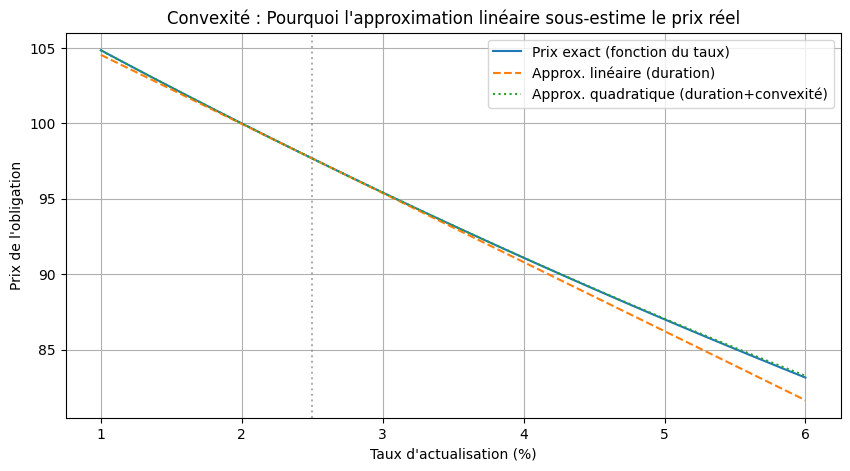

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres d'une obligation fictive
nominal = 100
coupon = 2
N = 5
r0 = 0.025

dates = np.arange(1, N+1)
cashflows = [coupon] * (N-1) + [coupon + nominal]

# Génère une large gamme de taux autour de r0
rates = np.linspace(0.01, 0.06, 100)
prices = []
for r in rates:
    dfs = [(1+r)**(-t) for t in dates]
    prices.append(sum(cf*df for cf, df in zip(cashflows, dfs)))
prices = np.array(prices)

# Calcul du prix initial, duration modifiée, convexité au taux r0
dfs0 = [(1+r0)**(-t) for t in dates]
P0 = sum(cf*df for cf, df in zip(cashflows, dfs0))
D_mac = sum(t * cf * df for t, cf, df in zip(dates, cashflows, dfs0)) / P0
D_mod = D_mac / (1 + r0)
Conv = sum(t*(t+1)*cf*df/(1+r0)**2 for t, cf, df in zip(dates, cashflows, dfs0)) / P0

# Approximations : linéaire (duration), quadratique (duration + convexité)
delta_r = rates - r0
P_linear = P0 - D_mod * P0 * delta_r
P_quadratic = P_linear + 0.5 * Conv * P0 * delta_r**2

# Plot
plt.figure(figsize=(10,5))
plt.plot(rates*100, prices, label="Prix exact (fonction du taux)")
plt.plot(rates*100, P_linear, '--', label="Approx. linéaire (duration)")
plt.plot(rates*100, P_quadratic, ':', label="Approx. quadratique (duration+convexité)")
plt.axvline(r0*100, color='grey', ls=':', alpha=0.6)
plt.xlabel("Taux d'actualisation (%)")
plt.ylabel("Prix de l'obligation")
plt.title("Convexité : Pourquoi l'approximation linéaire sous-estime le prix réel")
plt.legend()
plt.grid()
plt.show()


- La vraie courbe (prix/taux) est convexe : le prix baisse moins vite que la tangente.

- La droite linéaire (duration seule) est une bonne approximation pour de très petits moves.

- La courbe quadratique (duration+convexité) colle mieux, même sur de grands chocs.

- Moralité : la convexité protège contre les gros chocs de taux — d’où l’intérêt d’en avoir dans un portefeuille (en plus de la duration).


## 4. Chocs de courbe (parallèle, twist, butterfly)

- **Choc parallèle** : tous les taux montent/baisse du même montant
- **Twist** : les taux courts montent, les taux longs baissent (ou inversement)
- **Butterfly** : les taux intermédiaires bougent plus que courts/longs

**Exemple Python (visualisation du prix selon le taux d'actualisation) :**


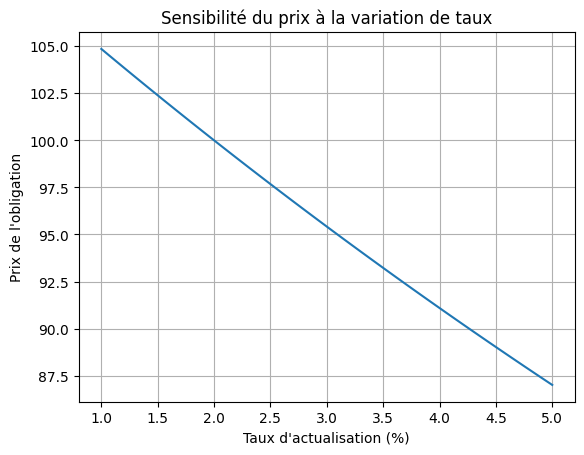

In [4]:
import matplotlib.pyplot as plt
rs = np.linspace(0.01, 0.05, 100)
prices = []
for r_ in rs:
    dfs = [(1+r_)**(-t) for t in dates]
    prices.append(sum(cf*df for cf, df in zip(cashflows, dfs)))
plt.plot(rs*100, prices)
plt.xlabel("Taux d'actualisation (%)")
plt.ylabel("Prix de l'obligation")
plt.title("Sensibilité du prix à la variation de taux")
plt.grid()
plt.show()



## 5. (Bonus) Calcul DV01 d’un portefeuille

Supposons 3 obligations, tu veux le DV01 total.  
Exemple :  
- Obl1 : P1, D1, DV01_1
- Obl2 : P2, D2, DV01_2
- ...

Le **DV01 du portefeuille** = somme des DV01 pondérés par la position.



In [ ]:

# Trois bonds, paramètres arbitraires
params = [
    {"N": 3, "c": 2, "r": 0.015},   # Bond court
    {"N": 5, "c": 3, "r": 0.02},    # Moyen terme
    {"N": 10, "c": 4, "r": 0.03},   # Long terme
]
dv01s = []
for par in params:
    cashflows = [par["c"]] * (par["N"]-1) + [par["c"]+100]
    dates = np.arange(1, par["N"]+1)
    dfs = [(1+par["r"])**(-t) for t in dates]
    P = sum(cf*df for cf, df in zip(cashflows, dfs))
    D_mac = sum(t * cf * df for t, cf, df in zip(dates, cashflows, dfs)) / P
    D_mod = D_mac / (1 + par["r"])
    dv01 = -D_mod * P * 0.0001
    dv01s.append(dv01)

# Position : 1M sur chaque bond
pos = np.array([1e6, 1e6, 1e6])
port_dv01 = np.dot(pos, dv01s)
print(f"DV01 total portefeuille (3 bonds, 1M chacun) : {port_dv01:.2f} € pour +1bp")

DV01 total portefeuille (3 bonds, 1M chacun) : -167565.43 € pour +1bp


[{'N': 3, 'c': 2, 'r': 0.015},
 {'N': 5, 'c': 3, 'r': 0.02},
 {'N': 10, 'c': 4, 'r': 0.03}]


---
## 📝 **À retenir pour l’entretien (fiche orale)**

- **Duration/DV01** = outils clefs pour mesurer et piloter le risque taux
- **Convexité** = sécurité en cas de gros mouvement de taux (asymétrie prix/taux)
- **Choc parallèle** = tous les taux bougent pareil
- **Twist** = pente de courbe change (stratégie de spread)
- **DV01 total = la sensibilité clé pour un trader rates**
- Toujours donner l’ordre de grandeur DV01 en € pour 1bp

---
